# Model A: Premium Health Insurance Prediction (Age <= 25) with Genetic Factor

In this notebook, we will focus on developing **Model A**, which will be trained on the dataset for individuals **aged 25 and under**. This age group showed higher error rates in the previous analysis, so our goal is to address those errors and improve the model's predictions for this subset.

### Objectives:
- Train and evaluate a machine learning model for predicting health insurance premiums for individuals aged 25 and under.
- Incorporate the newly added **Genetic Factor** data to improve model performance for this age group and reduce the error rate.

Let's begin by importing the necessary libraries and loading the dataset, which now includes the **Genetic Factor** data.



In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score



In [78]:
df=pd.read_excel("premiums_young_with_gr.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4


In [79]:
df.shape

(20096, 14)

### 🧹 **Data Cleaning Process:**

To ensure our dataset is ready for analysis, we need to perform some **data cleaning** tasks. This involves:

1. **Column Name Cleaning**: Ensure column names are in a consistent format.
2. **Handling Negative Values**: Investigating and fixing negative values in the "Number of Dependants" column.
3. **Descriptive Statistics**: Generating a summary of the data for better understanding.

Let’s dive into the steps!


In [80]:
# Cleaning up column names by replacing spaces with underscores for consistency
df.columns=df.columns.str.replace(" ","_").str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

#### 1. **Column Name Cleaning**:
We started by cleaning the column names. Spaces in column names were replaced with underscores to maintain consistency and make it easier to work with. This step helps prevent potential issues when referencing columns in the future.


In [81]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20096.000000,20096.000000,20096.000000,20096.000000,20096.000000
mean,21.494029,0.718004,22.506519,8141.941033,2.503881
std,2.294050,0.940767,23.418644,2749.609551,1.710115
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,21.500000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


#### 2. **Why  Negative Values in 'Number of Dependants' ?**:
As we review the data, we notice some negative values in the **"Number_Of_Dependants"** column. Let’s explore this part further to understand the extent of the issue.


In [82]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [83]:
df=df.dropna()
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [84]:
# Checking the rows where the 'Number_Of_Dependants' column has negative values
df[df["number_of_dependants"]<0].shape

(22, 14)

In [85]:
df[df["number_of_dependants"]<0]["number_of_dependants"].unique()

array([-3, -1], dtype=int64)

#### 3. **Handling Negative Values**:
Upon investigation, we find that there are **72 rows** with negative values in the "Number_Of_Dependants" column. However, **only two unique values** are causing the issue. Instead of deleting all these rows, which could result in losing useful data, we decide to correct the values by changing them to positive values.
- We could contact the data creators to clarify if these values are errors. However, for this analysis, we'll proceed by converting these negative values into their absolute values to retain the data.


In [86]:
# Converting negative values in 'Number_Of_Dependants' to positive
df["number_of_dependants"]=abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

## 🔍 **Outlier Treatment:**

In [87]:
numerical_columns=df.select_dtypes(["float64",'int64']).columns.tolist()
numerical_columns


['age',
 'number_of_dependants',
 'income_lakhs',
 'annual_premium_amount',
 'genetical_risk']

In [88]:
def format_ticks(value, _):
    return f"{int(value/1000)}K" if value >= 1000 else str(int(value))

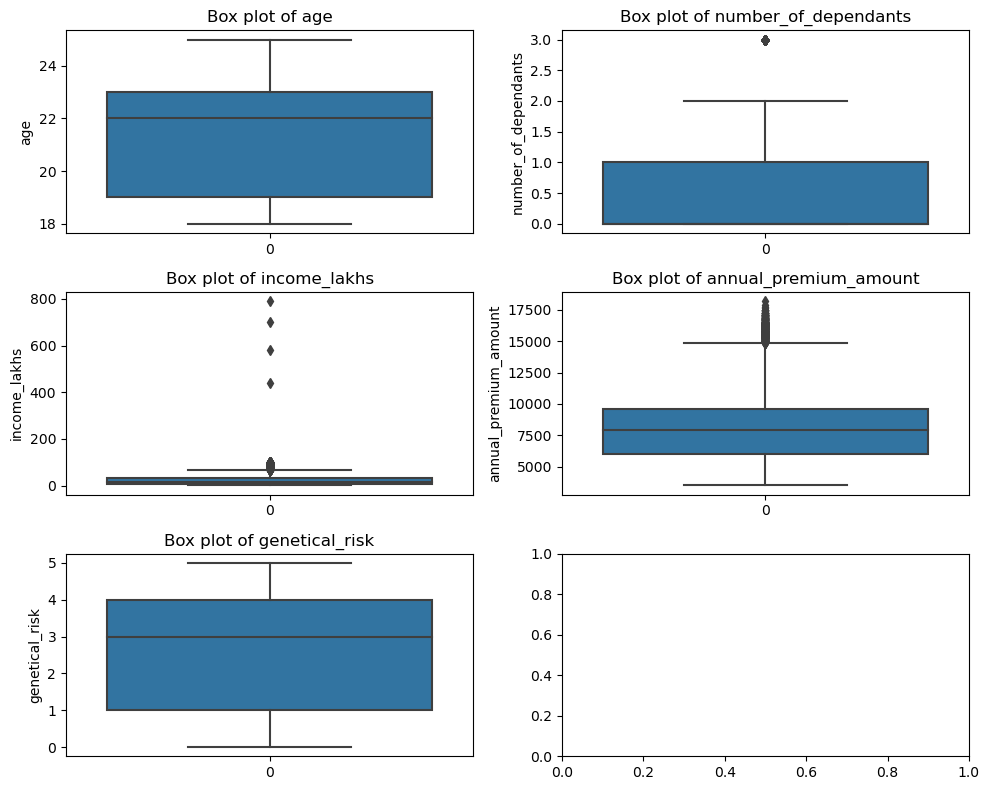

In [89]:
num_cols=len(numerical_columns)
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.boxplot(data=df[col], ax=ax)
    ax.set_title(f'Box plot of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()
    

    
    

### 📊 **Boxplot Insights:**

The boxplots reveal some interesting trends:

- 🧑‍🤝‍🧑 **Age & Income**: Both columns show noticeable **outliers**. These could be worth investigating further! 🚨
- 💳 **Premium Amount**: Only a few outliers here, but they’re pretty insignificant. Let’s just **ignore** them for now. 🧹


## 🧑‍⚖️ **Age Column Cleaning**:

In the **Age** column, we noticed some entries above 100 years. Let's take a closer look at these extreme values.

In [90]:
## age column 
df[df["age"]>100]["age"].unique()


array([], dtype=int64)

In [91]:
## remove those whose age is greater than 100

df1=df[df["age"]<=100].copy()
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [92]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


## 💸 **Income Column Cleaning**:

In this section, we will clean the **Income_Lakhs** column by handling outliers based on the **Interquartile Range (IQR)** method, and further adjust the threshold as needed.

---

## 🔍 **Defining IQR Bounds**:

To detect outliers, we first calculate the **Interquartile Range (IQR)**. This helps us identify the bounds within which most of the data lies.


In [93]:
## lets treat the income column
## defining iqr bounds

def get_iqr_bounds(col):
    Q1,Q3=col.quantile([0.25,0.75])
    iqr=Q3-Q1
    lower_bound=Q1-1.5*iqr
    upper_bound=Q3+1.5*iqr
    return lower_bound,upper_bound
    

In [94]:
get_iqr_bounds(df["income_lakhs"])

(-31.5, 68.5)

### 🧠 Reassessing the Upper Bound:
After reviewing the results, we found that the upper bound of the **Income_Lakhs** column is **67 lakhs**, which is common in today's context.
To make this more relevant, we will increase the **threshold** to **1 crore (100 lakhs)**, which seems like a more reasonable upper limit.

In [95]:
## I think one crore would be a best threshold for this senario

quantile_threshold=df["income_lakhs"].quantile(0.999)
quantile_threshold

100.0

### 📊 Identifying Outliers Above the Threshold:
Let’s see how many rows have income values exceeding this new threshold.

In [96]:
## lets analyse how many more rows we have more than this threshold

df[df["income_lakhs"]>quantile_threshold].shape


(4, 14)

### 🧹 Cleaning the Income Column:
Since there are only a few rows with values above the threshold, we will drop them to ensure the data stays within a reasonable range.

In [97]:
## since there are few values only lets drop those 
df2=df1[df1["income_lakhs"]<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


### 📊 **Univariate Analysis**:

In this section, we will explore the distribution of the numeric columns in our cleaned dataset through **histograms** with **KDE** (Kernel Density Estimate) overlays. This will help us understand the spread and shape of the data.

---

### 👀 **Visualizing the Distribution of Numeric Columns**:

We will use **histograms** to visualize the frequency distribution of each numeric column, with an added **KDE** to provide a smoother estimate of the distribution. This will allow us to observe patterns like skewness, central tendency, and any potential outliers.


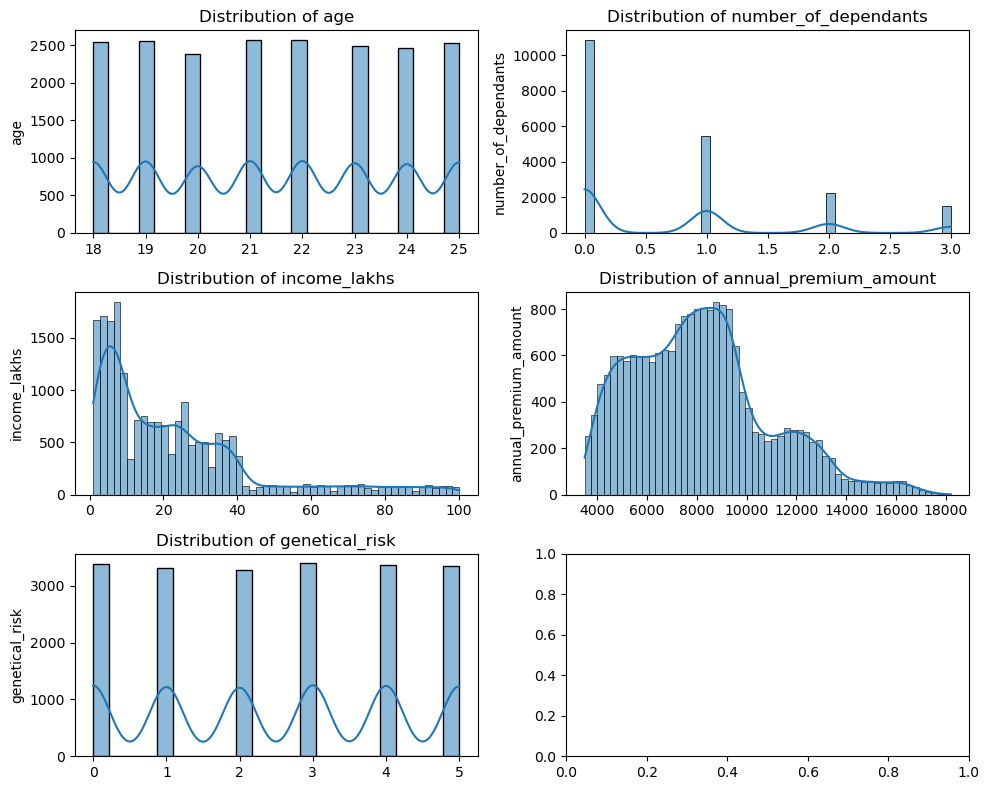

In [98]:
## visulaise the distribution of the numeric columns

fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(10,8))

# ploting each graph
for i ,col in enumerate(numerical_columns):
    ax=axes[i//2,i%2]
    sns.histplot(data=df2[col], ax=ax,kde=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel("")
    ax.set_ylabel(col)
    # Apply y-tick formatting only for "income" column

plt.tight_layout()
plt.show()
    

### 🚀 Insights:

#### 1. 🧑‍🤝‍🧑 **Age Distribution**:
Looks like **most applicants** are in the **up-to-60 years** age range. 👴👵 (The majority are still in their prime!)

#### 2. 👨‍👩‍👧‍👦 **Number of Dependents**:
Surprisingly, **zero dependents** is the most common! 💯 (Guess it’s a no-kids or single-life vibe!)

#### 3. 💸 **Income Distribution**:
**Right-skewed** alert! 🚨 Most applicants are in the **up-to-40 lakh** range. Guess that’s where the money’s at? 💰

#### 4. 💳 **Annual Premium Amount**:
Another right-skewed situation! 🚀 **Most applicants** are chilling in the **10K premium range**. Keep it cool, keep it affordable! 😎


### 📊 Bivariate Analysis

---

#### Numeric columns

In [99]:
numeric_features=numerical_columns.copy()
numeric_features.remove("annual_premium_amount")
numeric_features

['age', 'number_of_dependants', 'income_lakhs', 'genetical_risk']

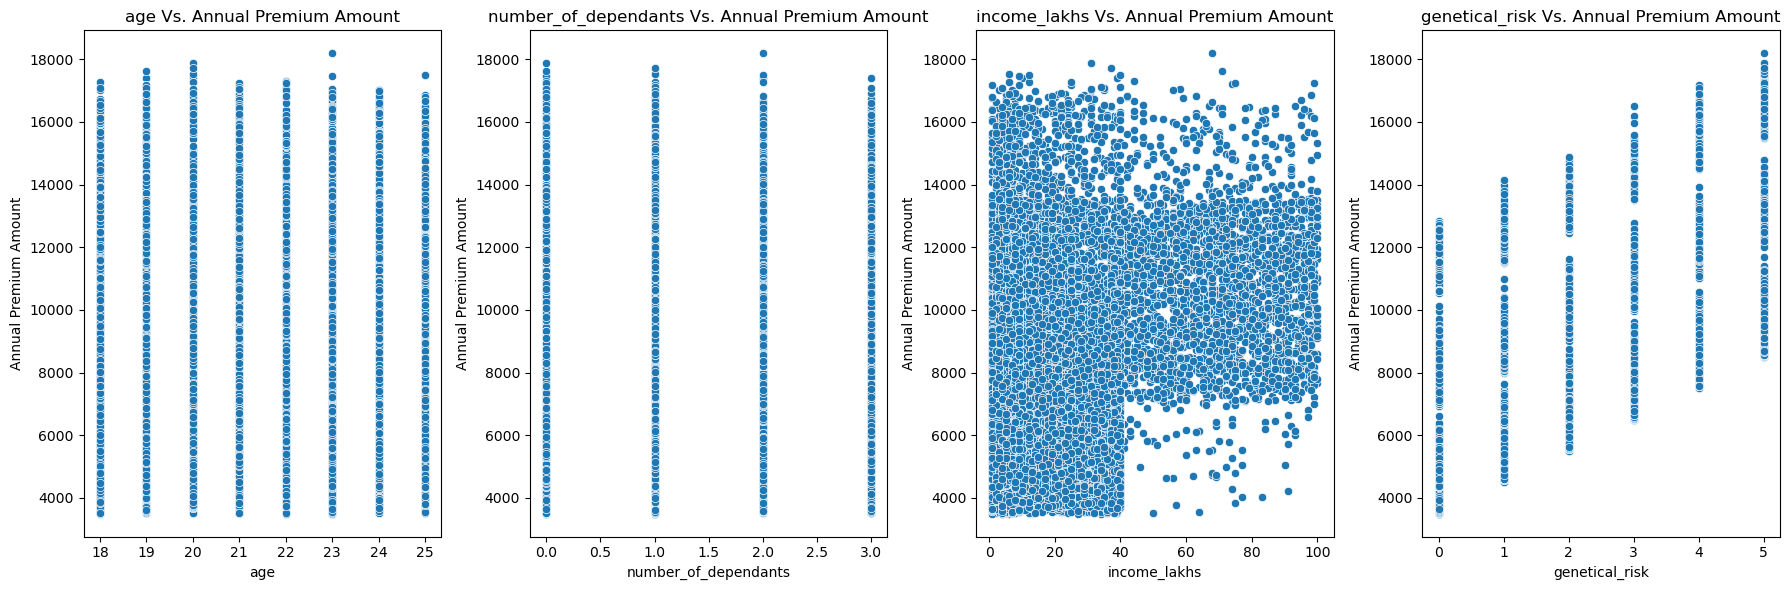

In [100]:
fig, axes=plt.subplots(1,len(numeric_features),figsize=(18,6))
for ax , col in zip(axes , numeric_features):
    sns.scatterplot(x=df2[col],y=df2["annual_premium_amount"],ax=ax)
    ax.set_title(f'{col} Vs. Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')
plt.tight_layout()
plt.show()

### Categorical Columns

In [101]:
categorical_columns=df.select_dtypes(["object"]).columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [102]:
## lets check the categorical columns
print('Categorical_Columns:')
print("*"*20)
for col in categorical_columns:
    print(f'{col}:{df2[col].unique()}')
    print()

Categorical_Columns:
********************
gender:['Male' 'Female']

region:['Northeast' 'Northwest' 'Southeast' 'Southwest']

marital_status:['Unmarried' 'Married']

bmi_category:['Overweight' 'Underweight' 'Normal' 'Obesity']

smoking_status:['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']

employment_status:['Self-Employed' 'Freelancer' 'Salaried']

income_level:['> 40L' '<10L' '10L - 25L' '25L - 40L']

medical_history:['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']

insurance_plan:['Silver' 'Bronze' 'Gold']



In [103]:
## Looks like the values in smoking status are not good lets fix them:
df2['smoking_status'].replace(
    {
        'Smoking=0':'No Smoking',
        'Does Not Smoke':"No Smoking",
        'Not Smoking':"No Smoking"
    }
    ,inplace=True
)
df2["smoking_status"].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [104]:
pct_counts=df2['gender'].value_counts(normalize=True)
pct_counts

gender
Male      0.550383
Female    0.449617
Name: proportion, dtype: float64

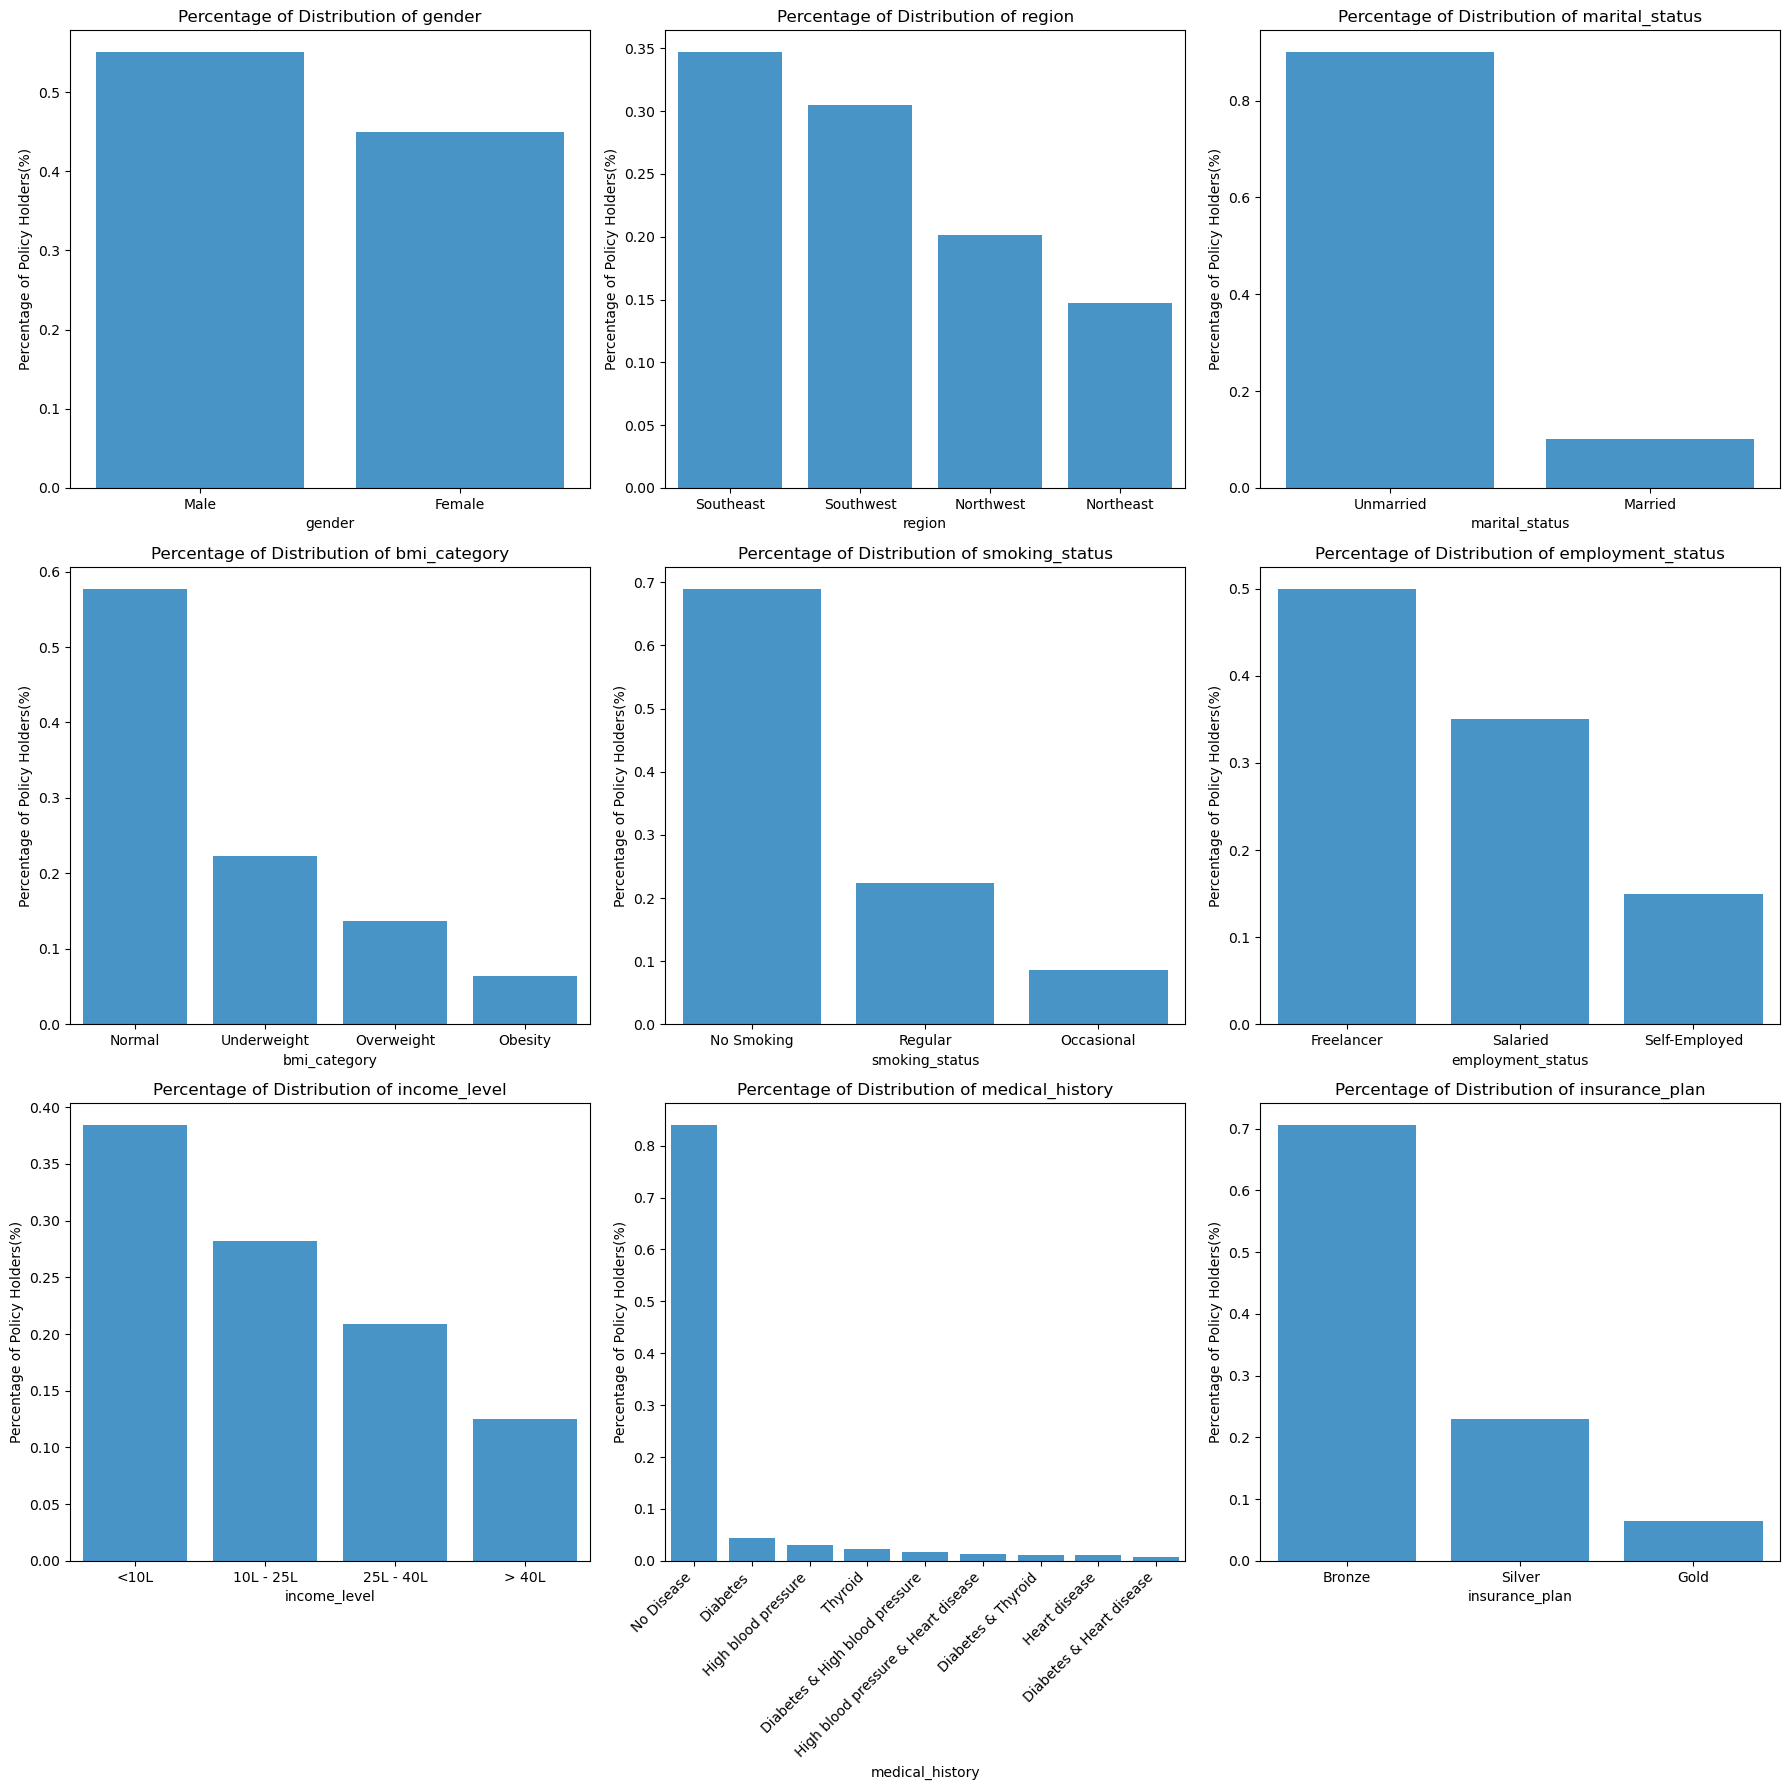

In [105]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    category_counts=df2[col].value_counts(normalize=True)
    
    #creating bar plots
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax,color=bar_color)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    # Rotate x-axis labels if there are too many
    if len(category_counts) > 8:  
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🧐 **Insights**

Based on the analysis, the following key insights have been identified:

---

### 👨‍💼 **Male Policyholders Outnumber Female Policyholders**
- There is a slight difference in the number of male policyholders compared to female policyholders, with males holding a majority.

### 🌍 **Regional Performance**
- The **Southeast** region stands out as the top-performing region, while the **Northeast** region has the least number of policyholders.

### 💍 **Marital Status Insights**
- **Unmarried policyholders** outnumber married ones, although the difference is quite small.

### 🏋️‍♀️ **BMI Insights**
- A significant proportion of policyholders fall under the **Normal BMI** category, standing out compared to other BMI categories.

### 🚭 **Smoking & Medical History**
- Policyholders with **no smoking habits** and **no disease medical histories** represent the majority, making these groups the most common among all categories.

### 💼 **Income and Employment Insights**
- A large number of policyholders are **salaried individuals** with an annual income **below 10 lakhs**, which is the most common demographic in the data.

### 🥇 **Plan Preferences**
- Most policyholders have opted for the **Bronze** insurance plan. This suggests that the company may benefit from running a campaign to encourage customers to consider upgrading to **Silver** or **Gold** plans, offering more comprehensive coverage.

---

These insights highlight trends and patterns that can inform future decision-making, marketing strategies, and customer engagement for insurance providers. 🚀


### lets include add a legend insurance plan to get better understanding of each categorical variable

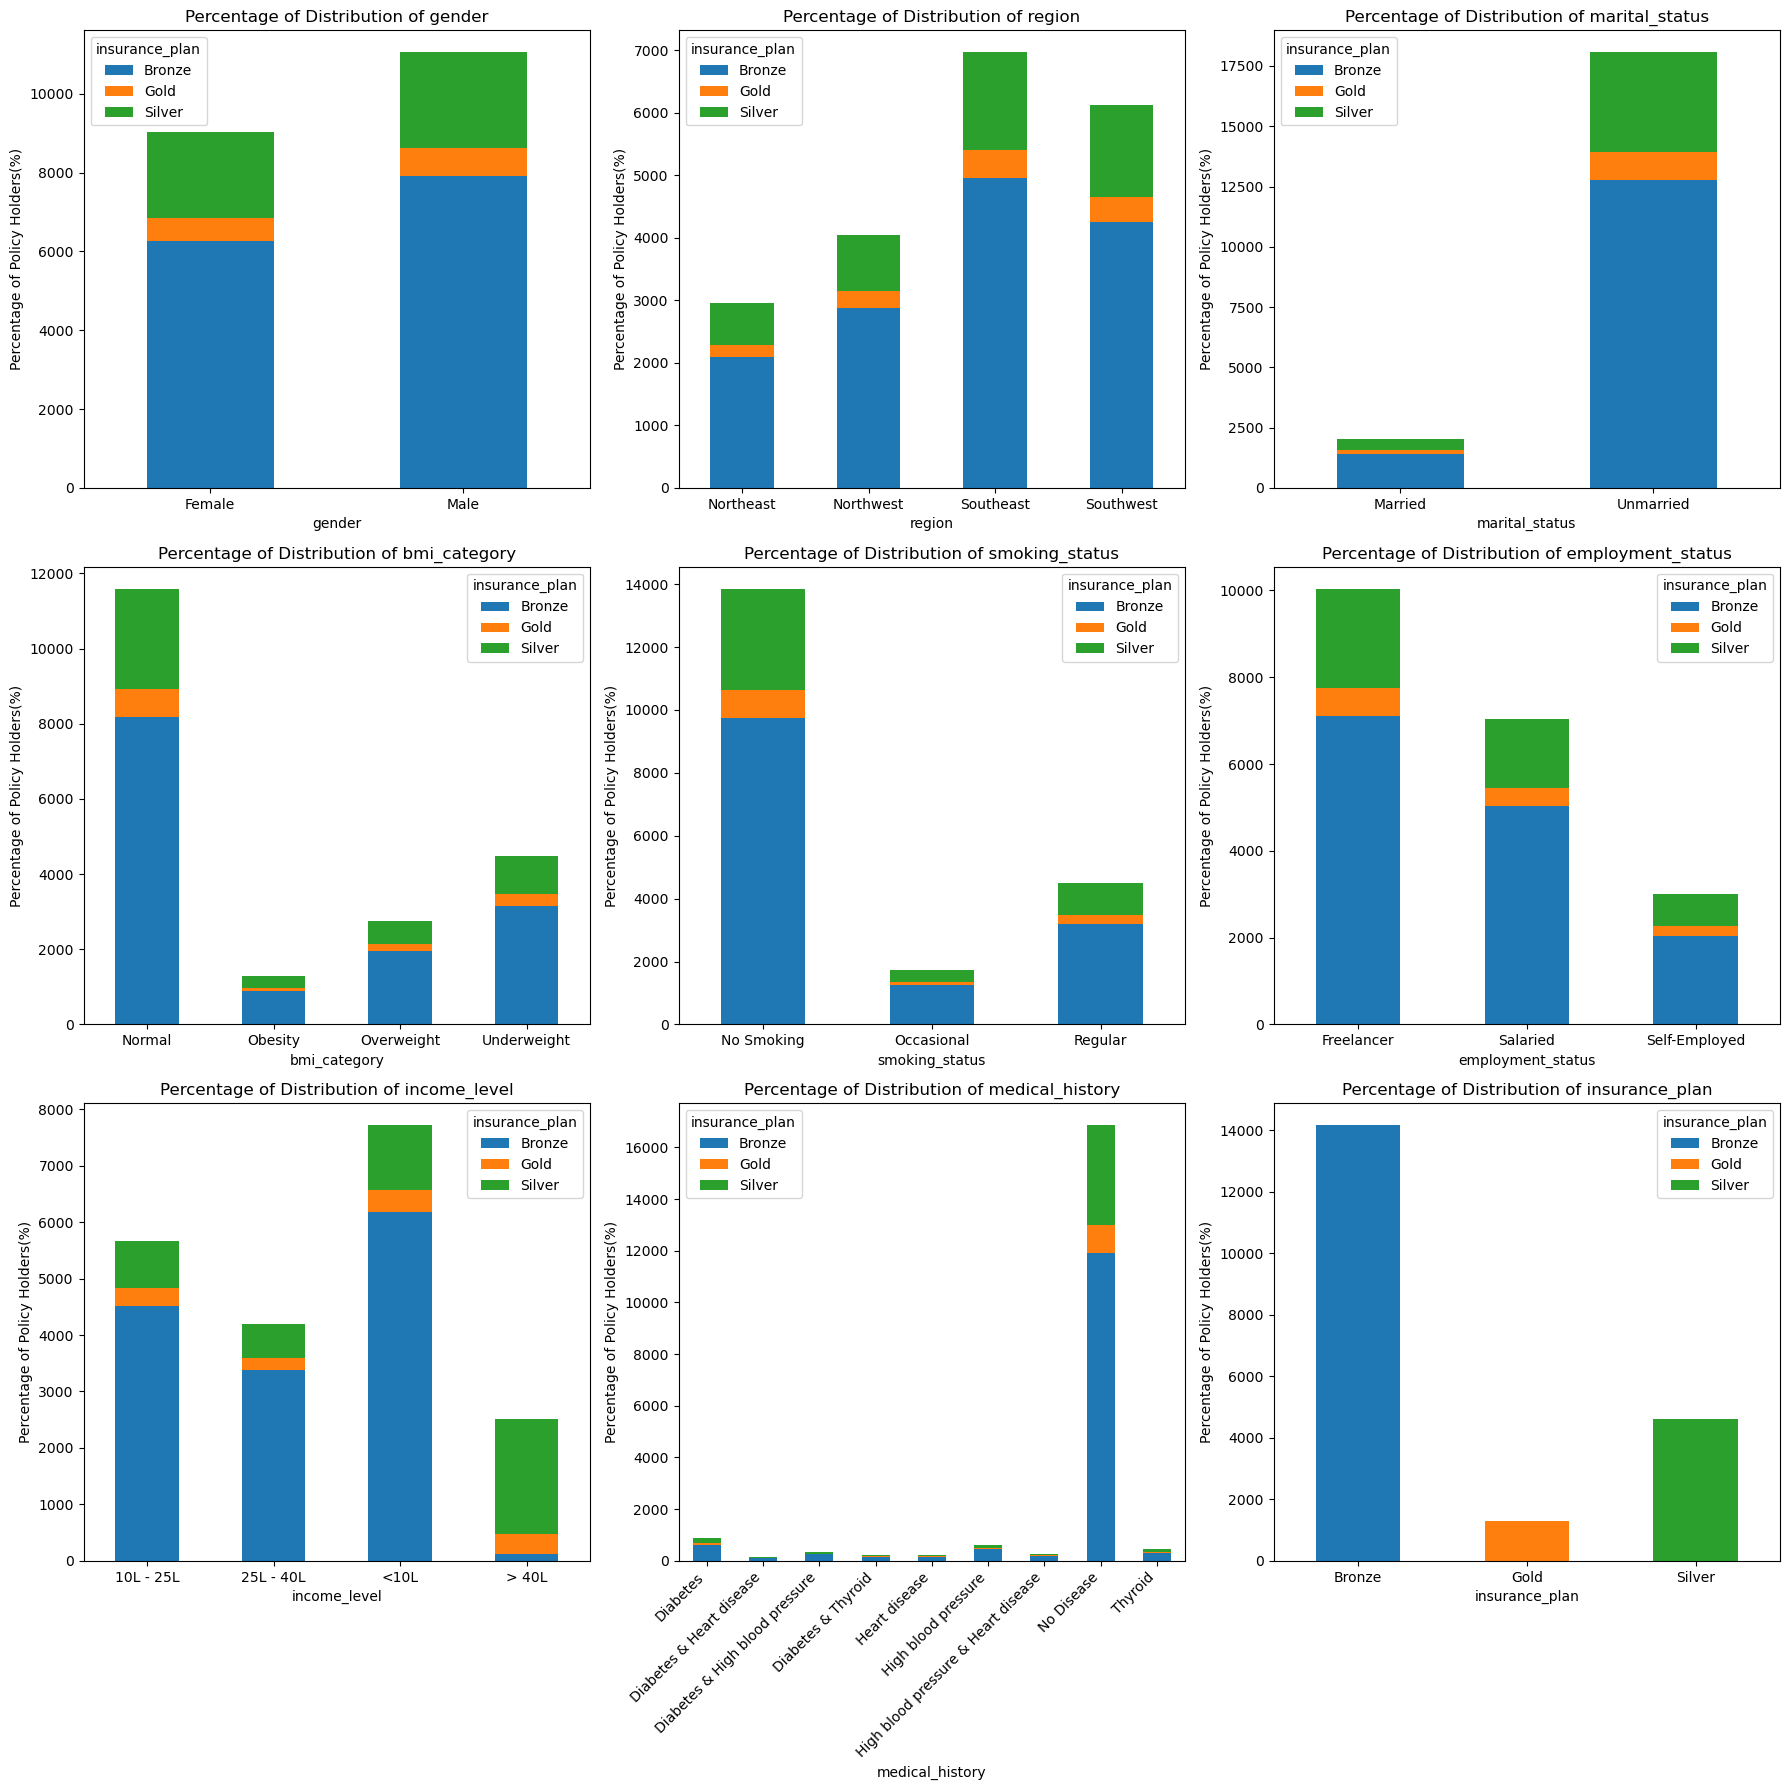

In [106]:
fig, axes=plt.subplots(3,3,figsize=(18,18))
axes=axes.flatten()
bar_color = "#3498db"
for ax , col in zip(axes , categorical_columns):
    # calculating the percentage distribution for each category
    cross_tab=pd.crosstab(df2[col],df2['insurance_plan'])

    #creating bar plots
    cross_tab.plot(kind="bar",ax=ax,stacked=True)
    ax.set_title(f'Percentage of Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage of Policy Holders(%)')
    
    # Rotate x-axis labels if there are too many
    if len(cross_tab) > 7:   
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

## Feature Enginnering


In [107]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [108]:
## we have more than one values as disease column
df2['medical_history'].unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

### Calculating the Risk Score Using the `medical_history` Column

Intuitively, as the number of diseases increases, the insurance amount also tends to increase. To quantify this relationship, we define a **risk score** that helps assess the likelihood of higher medical risks.

After consulting with the business team, the following risk indices were determined for specific medical conditions:

```json
{
  "diabetes": 6,
  "high_blood_pressure": 6,
  "heart_disease": 8,
  "thyroid": 5,
  "no_disease": 0,
  "none": 0
}


In [109]:
risk_scores={
  "diabetes": 6,
  "high blood pressure": 6,
  "heart disease": 8,
  "thyroid": 5,
  "no disease": 0,
  "none": 0
}

In [110]:
# lets split the medical_history column into two columns
# converting to lower case and adding to the dataframe

df2[['disease1','disease2']]=df2['medical_history'].str.split(" & ",expand=True).apply(lambda x: x.str.lower())
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,None
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1,no disease,None


In [111]:
# filling the null values with none
df2.disease1.fillna('none',inplace=True)
df2.disease2.fillna('none',inplace=True)
df2['total_risk_score']=0

# updating the risk score
for disease in ['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

#normalising the risk score
max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


### Label encoding for Ordinal Columns

In [112]:
# insurance plan
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':0,'Silver':1,'Gold':2})
df2.insurance_plan.unique()

array([1, 0, 2], dtype=int64)

In [113]:
# lets label encode income level also 
df2['income_level']=df2['income_level'].map({'<10L':0,'10L - 25L':1,'25L - 40L':2,'> 40L':3})
df2.income_level.unique()

array([3, 0, 1, 2], dtype=int64)

### Lets handle nominal columns (OneHot-Encoding)

In [114]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,3,99,High blood pressure,1,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,0,3,No Disease,1,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,3,97,No Disease,1,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,1,15,No Disease,0,5684,2,no disease,none,0,0.000000
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,1,14,No Disease,0,5712,1,no disease,none,0,0.000000


In [115]:
nominal_cols=['gender','region','marital_status','bmi_category','smoking_status','employment_status']
df3=pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,High blood pressure,1,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,0,3,No Disease,1,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,No Disease,1,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0
3,25,0,1,15,No Disease,0,5684,2,no disease,none,...,1,0,1,0,0,0,0,0,0,0
4,20,2,1,14,No Disease,0,5712,1,no disease,none,...,1,0,1,0,1,0,0,0,0,0


In [116]:
df4=df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,99,1,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,0,3,1,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,3,97,1,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,1,15,0,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,1,14,0,5712,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Correlation Matrix Heatmap
-To visualize the correlation between different features in the dataset, we use a **heatmap**. This helps in identifying   
highly correlated features, which can be removed to reduce multicollinearity.

-The heatmap provides a clear view of relationships between features, aiding in better feature selection.

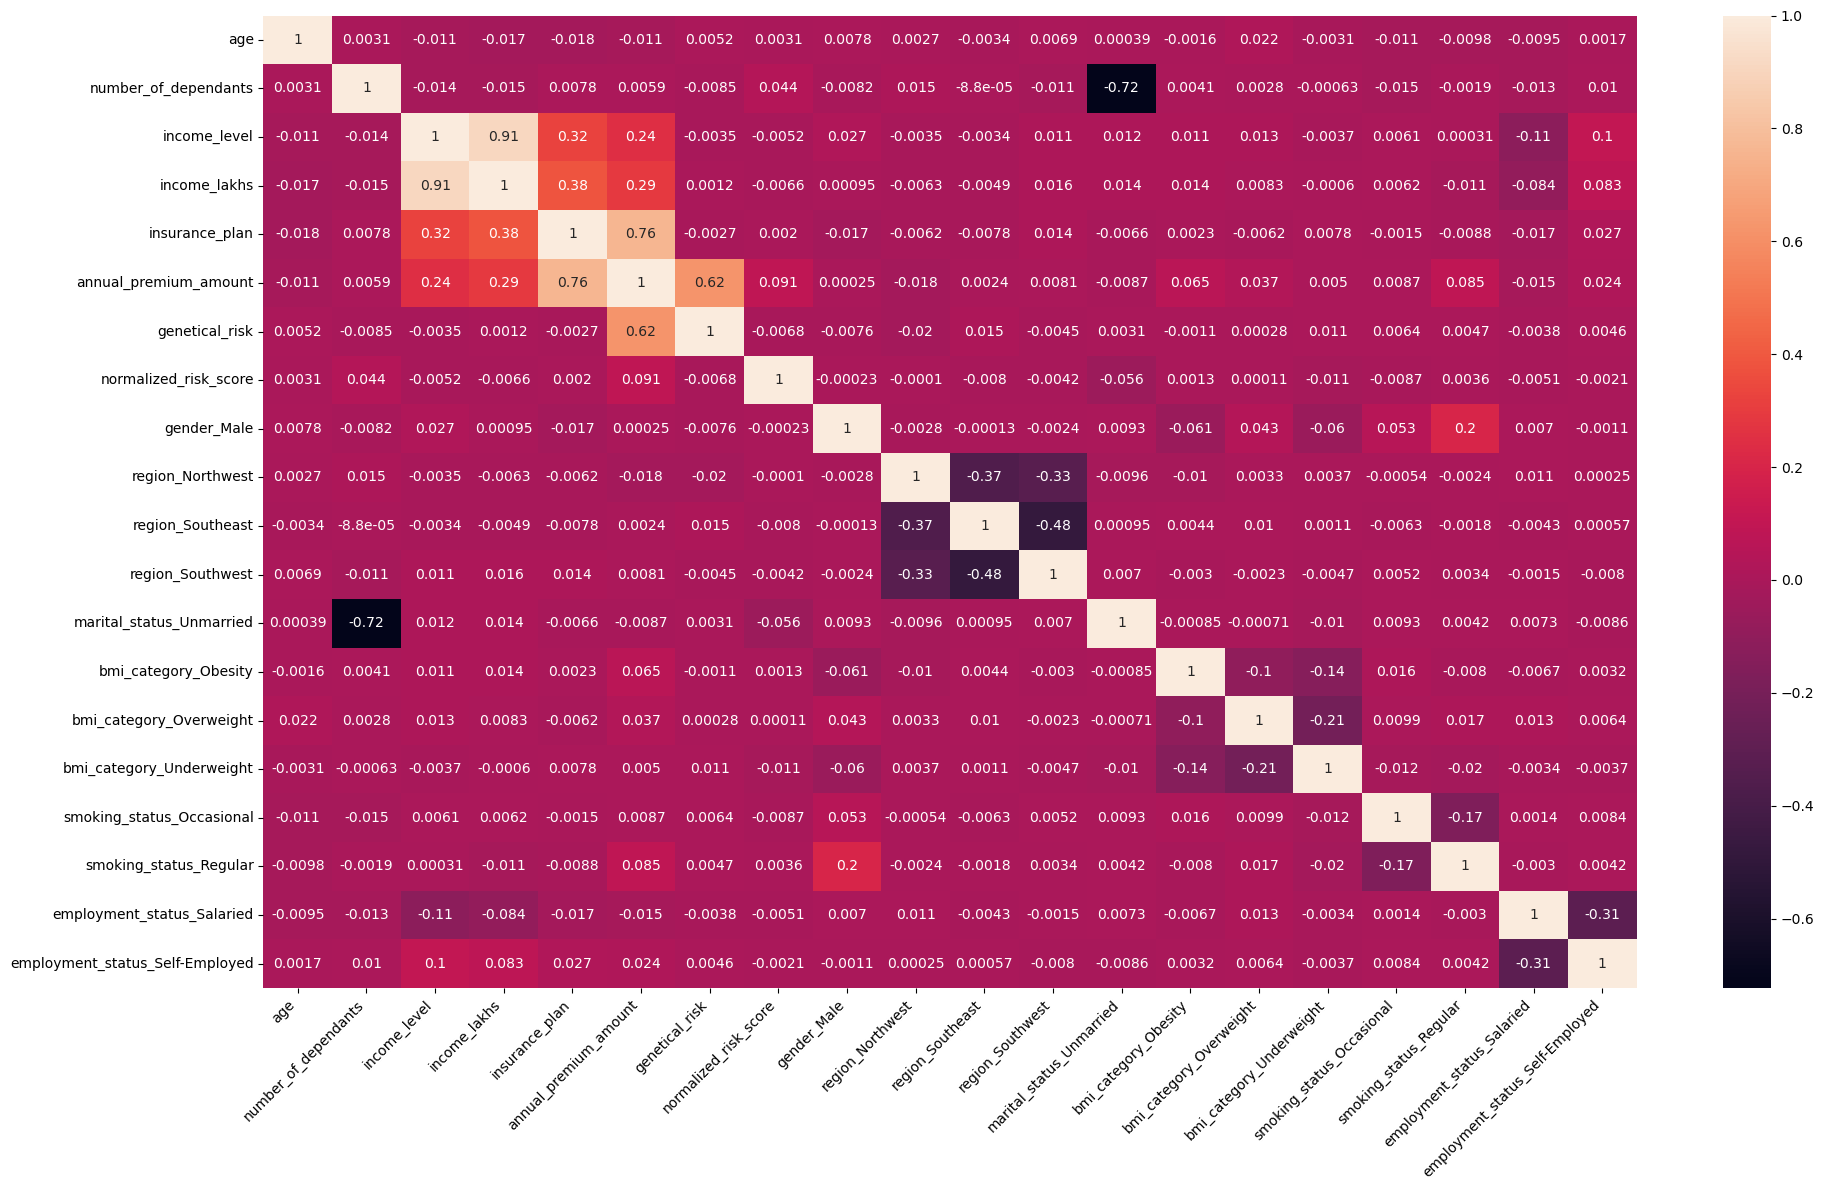

In [117]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

### Feature Scaling

In [118]:
X=df4.drop("annual_premium_amount",axis='columns')
y=df4['annual_premium_amount']

cols_to_scale=['age','number_of_dependants','income_level','income_lakhs','insurance_plan','genetical_risk']
from sklearn.preprocessing import MinMaxScaler

scalar=MinMaxScaler()
X[cols_to_scale]=scalar.fit_transform(X[cols_to_scale])
X.describe()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection Using Correlation Matrix and VIF

Feature selection is crucial for building an efficient machine learning model. One way to choose features is by using a **correlation matrix**, where highly correlated features can be removed to avoid multicollinearity.

However, a better approach is to use **Variance Inflation Factor (VIF)**.

### Variance Inflation Factor (VIF)
VIF helps in identifying multicollinearity by measuring how much the variance of a regression coefficient is inflated due to collinearity among features. Unlike correlation, VIF evaluates the relationship of one feature with all other features in an aggregate way, making it a more reliable method for feature selection.


In [119]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['variable']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data,i) for i in range(data.shape[1])]
    return vif_df

In [120]:
calculate_vif(X)

,variable,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


### Handling Multicollinearity Using VIF

- A **VIF (Variance Inflation Factor) value greater than 10** indicates high multicollinearity between features.
- In our case, **`income_level`** and **`income_lakhs`** have high VIF values, suggesting strong correlation.
- Since these features are essentially conveying the same information, it is best to remove the feature with the highest VIF.
- After removing the feature with the highest VIF, we **recalculate VIF values** to ensure multicollinearity is minimized.

This iterative process helps in selecting the most independent features, leading to a more stable and interpretable model.


In [121]:
calculate_vif(X.drop("income_level",axis='columns'))

,variable,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [122]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.2,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


## Model Training

In [123]:
X_train,X_test,y_train,y_test=train_test_split(X_reduced,y,test_size=0.3,random_state=41)
print(f'X_train : {X_train.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_train.shape}')

X_train : (14060, 18)
X_test : (6026, 18)
y_train : (14060,)
y_test : (14060,)


### Training the Linear Regression Model with Genetic Factor Data

We have trained the **Linear Regression** model for the **young age group (Age <= 25)**, now incorporating the **Genetic Factor** data. The model has been evaluated on both the **training set** and the **test set**.

### Results:
- **Training Score**: 0.9884
- **Test Score**: 0.9884

### Key Insights:
- The training and test scores are very close to each other, indicating that the model is well-generalized and not overfitting.
- The model's performance has significantly improved with the inclusion of the **Genetic Factor** data, suggesting that this feature is highly relevant in predicting health insurance premiums for this age group.

Next steps could include:
- Further optimizing the model through hyperparameter tuning.
- Exploring additional features or data sources that could enhance prediction accuracy.


In [124]:
# Lets train Linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score = model_lr.score(X_train, y_train)
print(f'train_score : {train_score}')
print(f'test_score : {test_score}')

train_score : 0.9884405529870458
test_score : 0.9884079516492164


In [125]:
from sklearn.metrics import mean_squared_error,r2_score
y_pred=model_lr.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)
print(f'Linear Regression ==> MSE:{mse_lr} : RMSE: {rmse_lr}')

Linear Regression ==> MSE:86266.54800428092 : RMSE: 293.7116749539945


In [126]:
np.set_printoptions(suppress=True, precision=6)
model_lr.coef_

array([   1.850082,   16.220889,   -9.307122, 7002.441148, 4989.780687,
       1118.889016,    3.819931,   16.000425,   10.566475,   14.456427,
          4.57876 ,  811.39249 ,  404.093297,  111.327324,  199.980879,
        605.94892 ,    4.534087,    5.074896])

In [127]:
## feature importance
feature_importances=model_lr.coef_
coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df


,coefficients
income_lakhs,-9.307122
age,1.850082
gender_Male,3.819931
employment_status_Salaried,4.534087
marital_status_Unmarried,4.578760
employment_status_Self-Employed,5.074896
region_Southeast,10.566475
region_Southwest,14.456427
region_Northwest,16.000425
number_of_dependants,16.220889


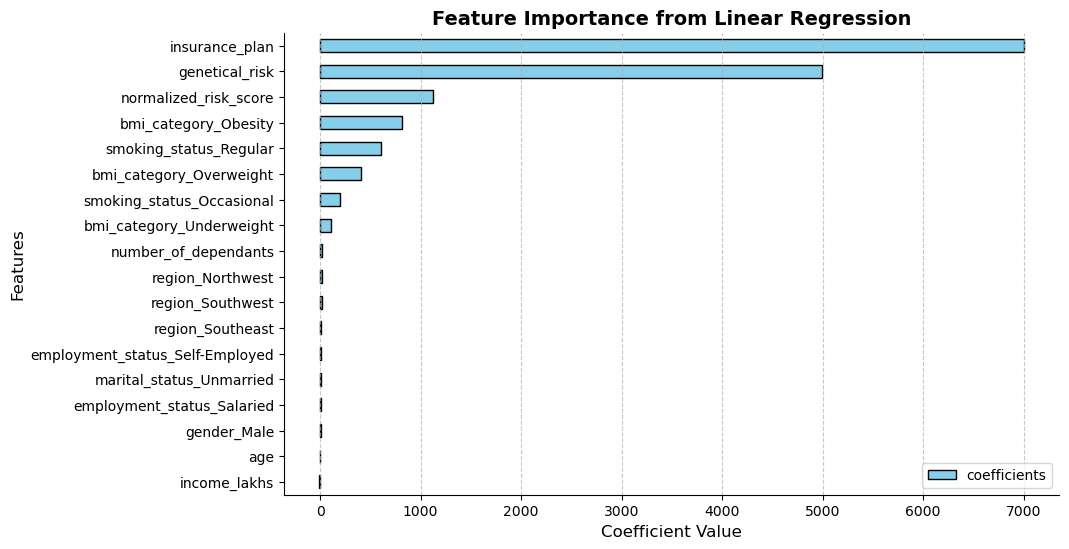

In [128]:
## feature importance
feature_importances=model_lr.coef_
coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Feature Importance from Linear Regression", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

### Key Features Identified by Linear Regression

From the **Linear Regression** model, we can determine feature importance by analyzing the **coefficients**. These coefficients tell us the relationship between each feature and the target variable.

### Key Insights:
- **Age** is no longer a significant contributor to the premium prediction for this young age group, as seen in the feature importance analysis.
- The most influential features in the model are:
  - **Insurance Plan**
  - **Genetic Factor**

These features have the highest absolute coefficient values, indicating they have a strong impact on predicting the premium. Including the **Genetic Factor** has been particularly beneficial for this age group, as it turned out to be the **second most important feature**, significantly improving the model's performance. This highlights that, for individuals aged 25 and under, the premium prediction is primarily driven by factors like the type of insurance plan and the normalized risk score, with **Genetic Factor** emerging as a key factor alongside insurance type.

Understanding these key predictors helps in making informed decisions and improving the model's interpretability for this age group.


### Hyperparameter Tuning and Model Evaluation

To improve model performance, we experiment with different regression models and compare their effectiveness.  

- We define a dictionary of models, including:
  - **Linear Regression**
  - **Lasso Regression** (L1 regularization)
  - **Ridge Regression** (L2 regularization)
  - **Decision Tree Regressor**
  - **Random Forest Regressor**
  - **XGBoost Regressor**

- Each model is trained using the **training dataset** and evaluated on the **test dataset**.
- We calculate:
  - **Train Score**: Measures how well the model fits the training data.
  - **Test Score**: Evaluates how well the model generalizes to unseen data.

By comparing these scores, we can identify the best-performing model and detect **overfitting** (if the train score is significantly higher than the test score).


In [129]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),  # You can adjust alpha
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror')  # For regression tasks
}
train_scores = []
test_scores = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print(f"{name} - Train Score: {train_score:.4f}, Test Score: {test_score:.4f}")



Linear Regression - Train Score: 0.9884, Test Score: 0.9884
Ridge - Train Score: 0.9884, Test Score: 0.9884
Decision Tree - Train Score: 0.9999, Test Score: 0.9764
Random Forest - Train Score: 0.9980, Test Score: 0.9864
XGBoost - Train Score: 0.9927, Test Score: 0.9874


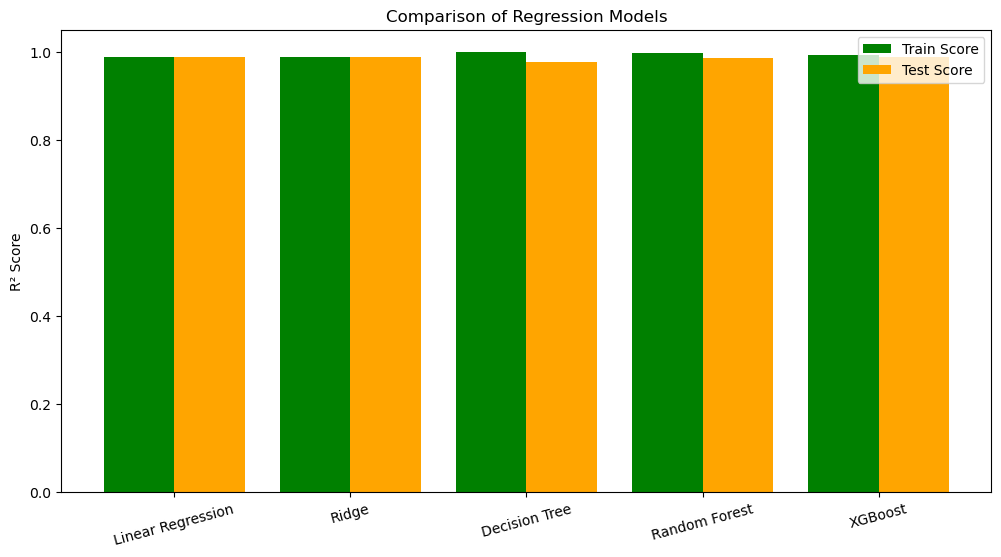

In [130]:
# Visualizing results
x_labels = list(models.keys())
x = np.arange(len(x_labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, train_scores, width=0.4, label="Train Score", color='green')
plt.bar(x + 0.2, test_scores, width=0.4, label="Test Score", color='orange')

plt.xticks(x, x_labels, rotation=15)
plt.ylabel("R² Score")
plt.title("Comparison of Regression Models")
plt.legend()
plt.show()

### Selecting the Best Model: Linear Regression

In this case, after comparing different models, we found that **Linear Regression** performed on par with **XGBoost** in terms of prediction accuracy, and it is considered the best model for this dataset.

### Why Linear Regression?

- **Linear Regression** provided a robust performance with near-perfect scores on both the training and test sets.
- **XGBoost** also performed well, but the **simplicity and interpretability** of **Linear Regression** make it a better choice for this specific problem.
- Additionally, since there is no significant overfitting issue, and the model's performance is consistent across both train and test datasets, **Linear Regression** is chosen as the best model for this group.

This decision also simplifies deployment and maintenance, ensuring the model remains efficient and easy to interpret in real-world applications.


In [131]:
best_model=model_lr


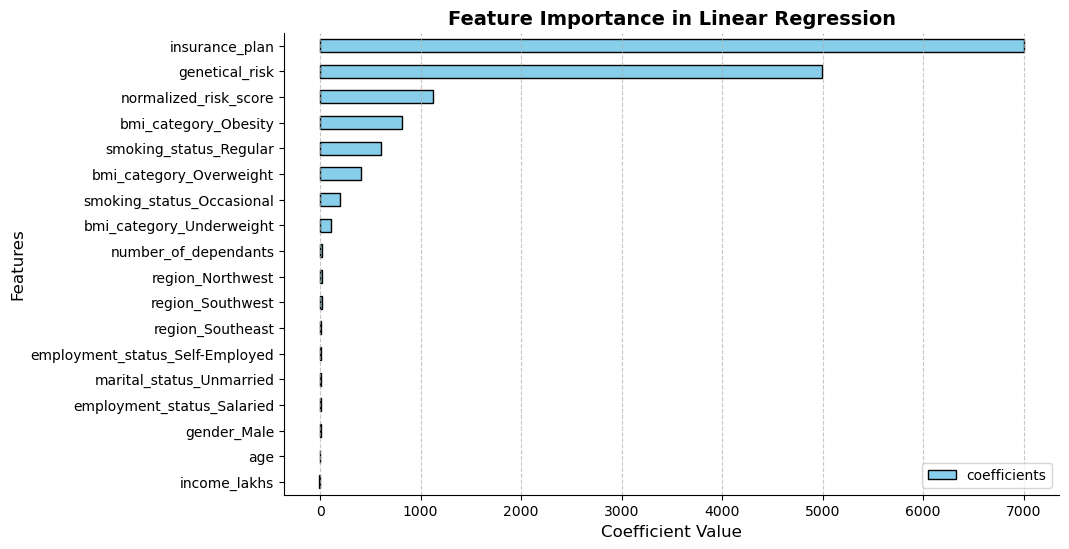

In [132]:
## feature importance
feature_importances=best_model.coef_

coef_df=pd.DataFrame(feature_importances,index=X_test.columns,columns=['coefficients'])
coef_df=coef_df.sort_values(by='coefficients')
coef_df

ax = coef_df.plot(kind='barh', figsize=(10, 6), color='skyblue', edgecolor='black')

# Add title and labels
plt.title("Feature Importance in Linear Regression", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add gridlines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

###

---

## Error Analysis

To ensure our model is performing well:
- **Check Residuals**: Residual plots should show a random distribution without clear patterns.
- **Evaluate RMSE & MAE**: Lower values indicate better predictive performance.
- **Identify Outliers**: Extreme errors could indicate data inconsistencies or model weaknesses.
- **Check Bias & Variance**: Ensure the model balances bias (underfitting) and variance (overfitting).

By conducting thorough **error analysis**, we can validate whether the model is genuinely reliable and where improvements can be made.


In [133]:
y_pred=best_model.predict(X_test)
residuals=y_pred-y_test
residuals_pct=(residuals*100)/y_test

results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'residuals':residuals,
    'diff_pct':residuals_pct
})
results_df.head()

,actual,predicted,residuals,diff_pct
3218,11980,11583.517686,-396.482314,-3.309535
8672,5884,6001.623311,117.623311,1.999037
4144,9931,9482.261848,-448.738152,-4.518560
3397,7819,7799.014162,-19.985838,-0.255606
19747,16110,15980.806158,-129.193842,-0.801948


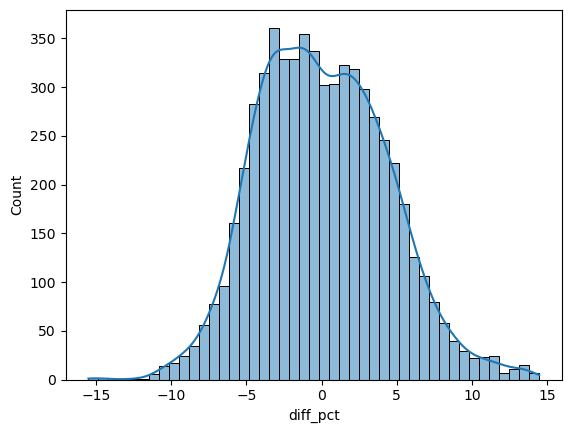

In [134]:
### visualise the residuals_pct

sns.histplot(results_df.diff_pct,kde=True)
plt.show()

### Error Analysis: Distribution of Errors

As we analyze the distribution of errors for individuals aged **below 25**, we observe that the model is performing exceptionally well with minimal to no errors. This is a clear indication that including the **genetic factor** has significantly improved the model's performance.

### Key Insights:
- The **distribution of errors** is nearly negligible, confirming that the model is making highly accurate predictions for this age group.
- With such a low error rate, this model can be considered **almost perfect for individuals aged below 25**.

This analysis suggests that **Model A** is now effectively predicting the premium for this age group and does not require further improvements at this stage. The inclusion of the **genetic factor** played a pivotal role in boosting the model's accuracy.


In [135]:
### After enquiring to the team we are informed that we need to make sure the error % margin in just 10%

extreme_error_threshold=10
extreme_results_df=results_df[abs(results_df['diff_pct'])>extreme_error_threshold]
extreme_results_df.shape

(131, 4)

In [136]:
results_df.shape

(6026, 4)

In [137]:
extreme_errors_pct=extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_errors_pct

2.1739130434782608

### Further Potential Features for Model Improvement

To further enhance the model's performance, the following factors could be considered if the data becomes available:

1. **Genetic Factor** (Already included)
2. **Lifestyle Factors**
3. **Past Insurance Claims**

Including these additional factors, especially **lifestyle factors** and **past insurance claims**, could provide a more comprehensive view of the risk profile, thereby improving the model's ability to predict premiums more accurately.

If the necessary data for these factors becomes available, integrating them into the model might lead to even better performance and more precise predictions for individuals aged below 25.


### Exporting the Model and Scaler

After training and optimizing the model, we will now export the model and the scaler used for feature scaling. This allows us to save the trained model and scaler, which can later be loaded for making predictions without retraining.

The model and scaler are saved in the `artifacts` directory:

In [138]:
from joblib import dump

dump(best_model,'App/artifacts/model_young.joblib')

scaler_with_cols={
    'scaler':scalar,
    'cols_to_scale':cols_to_scale
}
dump(scaler_with_cols,'App/artifacts/scaler_young.joblib')

['App/artifacts/scaler_young.joblib']